In [1]:
import pandas as pd
import alphalens as al
import numpy as np
from datetime import datetime
import statsmodels.api as sm

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
%run get_data.ipynb

## **新因子设计：**

使用**价量背离**的逻辑，最低价能代表当日交易情绪的低谷。

计算最低价与成交量过去10天的相关系数，相关性越高说明最低价与成交量越趋近于同涨同跌，最终结果加上负号，则近十天交易日的最低价与成交量的涨跌方向越趋向相反方向的因子值越高。

预想和实际的吻合程度不够高的原因可能是因为最低价是从开盘到收盘之间产生的交易价格，并不能像开盘价一样从开盘时就预示规律，也不能像收盘价一样有重要的盘面反馈。

## Alpha-new (-1 * correlation(low, volume, 10))

## 1.整理原始数据

In [4]:
price_data=(kline_data[['asset', 'low_price', 'date']].pivot_table(values='low_price', index='date', columns='asset')/10000).sort_index()
volume_data=(kline_data[['asset', 'volume', 'date']].pivot_table(values='volume', index='date', columns='asset')).sort_index()

In [5]:
price_data.head()

asset,000001.SZ,000002.SZ,000004.SZ,000005.SZ,000006.SZ,000007.SZ,000008.SZ,000009.SZ,000010.SZ,000011.SZ,...,873122.BJ,873132.BJ,873152.BJ,873167.BJ,873169.BJ,873223.BJ,873305.BJ,873339.BJ,873527.BJ,873576.BJ
date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,18.44,27.52,20.52,2.51,5.50,6.27,2.51,7.47,4.00,11.82,...,NaN,NaN,3.25,NaN,4.0,NaN,NaN,60.0,10.98,NaN
2021-01-05,17.80,27.10,20.60,2.46,5.39,5.64,2.49,7.68,3.97,11.67,...,NaN,NaN,3.25,NaN,4.0,NaN,5.70,60.0,10.98,NaN
2021-01-06,18.00,27.73,20.02,2.39,5.36,5.08,2.53,7.43,4.03,11.83,...,NaN,NaN,3.25,NaN,4.0,NaN,5.70,60.0,10.98,NaN
2021-01-07,19.23,28.39,18.88,2.36,5.21,4.57,2.57,7.55,3.99,11.05,...,NaN,NaN,3.25,NaN,4.0,NaN,5.70,60.0,10.98,NaN
2021-01-08,19.31,28.81,18.05,2.32,5.08,4.11,2.50,7.20,3.84,10.57,...,NaN,NaN,3.25,NaN,4.0,NaN,6.66,60.0,10.98,NaN


In [6]:
volume_data.head()

asset,000001.SZ,000002.SZ,000004.SZ,000005.SZ,000006.SZ,000007.SZ,000008.SZ,000009.SZ,000010.SZ,000011.SZ,...,873122.BJ,873132.BJ,873152.BJ,873167.BJ,873169.BJ,873223.BJ,873305.BJ,873339.BJ,873527.BJ,873576.BJ
date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,155421643.0,146844133.0,2739801.0,4896339.0,8132668.0,850900.0,13795696.0,81454236.0,18829709.0,7027182.0,...,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,0.0,NaN
2021-01-05,182135210.0,116265838.0,2304905.0,10317710.0,8532533.0,71435766.0,33215803.0,57578742.0,9823110.0,6146690.0,...,NaN,NaN,0.0,NaN,0.0,NaN,10000.0,0.0,0.0,NaN
2021-01-06,193494512.0,104880129.0,3183310.0,14822400.0,7183377.0,23693705.0,58454361.0,54967260.0,11326500.0,6987253.0,...,NaN,NaN,0.0,NaN,0.0,NaN,0.0,0.0,0.0,NaN
2021-01-07,158418530.0,122675574.0,4119880.0,9987378.0,10809106.0,6509500.0,34215256.0,82901381.0,9650301.0,13653804.0,...,NaN,NaN,0.0,NaN,0.0,NaN,0.0,0.0,0.0,NaN
2021-01-08,119547322.0,102856329.0,3841505.0,6593996.0,9108084.0,3607400.0,19792300.0,57526129.0,8790300.0,9798260.0,...,NaN,NaN,0.0,NaN,0.0,NaN,3101.0,0.0,0.0,NaN


## 2.定义函数

In [7]:
def correlation(x,y,window=10):
    return x.rolling(window).corr(y)

## 3.计算因子

In [8]:
factor_data=-1*correlation(price_data,volume_data,10)
factor_data=factor_data.replace([-np.inf,np.inf],0).fillna(value=0)

In [9]:
factor_data=factor_data.stack()
factor_data

date        asset    
2021-01-04  000001.SZ    0.000000
            000002.SZ    0.000000
            000004.SZ    0.000000
            000005.SZ    0.000000
            000006.SZ    0.000000
                           ...   
2021-12-31  873223.BJ    0.000000
            873305.BJ    0.720985
            873339.BJ    0.496020
            873527.BJ    0.608278
            873576.BJ    0.347503
Length: 1175877, dtype: float64

In [10]:
factor_data = factor_data.reset_index()
factor_data.rename(columns={0:'factor'}, inplace=True)
factor_data.head()

,date,asset,factor
0,2021-01-04,000001.SZ,0.0
1,2021-01-04,000002.SZ,0.0
2,2021-01-04,000004.SZ,0.0
3,2021-01-04,000005.SZ,0.0
4,2021-01-04,000006.SZ,0.0


## 4.合并数据

In [11]:
kline_data = kline_data.merge(share_data, on=['asset', 'date'])
kline_data['tcap'] = kline_data['close_price'] * kline_data['circulation_a']/10000
factor_data = factor_data.merge(kline_data[['asset', 'date', 'tcap', 'open_price', 'high_price', 'low_price', 'close_price', 'volume']], on=['asset', 'date'])
factor_data.head()
factor_data.shape[0]

1060558

In [12]:
factor_data = factor_data.merge(indus_data[['asset', 'date', 'first_industry_code']], on=['asset', 'date'])
factor_data=factor_data.merge(st_data[['asset','date','st']],on=['asset','date'])

## 5.剔除ST股票

In [13]:
factor_data = factor_data[factor_data['st'] != 1]
factor_data.head()

,date,asset,factor,tcap,open_price,high_price,low_price,close_price,volume,first_industry_code,st
0,2021-01-04,000001.SZ,0.0,3.609470e+11,191000.0,191000.0,184400.0,186000.0,155421643.0,40,0
1,2021-01-04,000002.SZ,0.0,2.698637e+11,284000.0,284000.0,275200.0,277800.0,146844133.0,42,0
2,2021-01-04,000004.SZ,0.0,1.763971e+09,206900.0,211900.0,205200.0,210200.0,2739801.0,35,0
3,2021-01-04,000005.SZ,0.0,2.666025e+09,25300.0,25300.0,25100.0,25200.0,4896339.0,20,0
4,2021-01-04,000006.SZ,0.0,7.442660e+09,56400.0,56400.0,55000.0,55200.0,8132668.0,42,0


## 6.剔除上市不满一年的股票

逻辑：按股票分组，获取每只股票的最早交易时间和最晚交易时间，相减得到交易总时间，不超过一年（这里设置为300天，时间更宽松一些）的剔除。

In [14]:
first_trade_dates = factor_data.groupby('asset')['date'].min()
last_trade_date = factor_data['date'].max()

trading_days = (last_trade_date - first_trade_dates).dt.days
stocks_less_than_a_year = trading_days[trading_days < 300].index

factor_data = factor_data[~factor_data['asset'].isin(stocks_less_than_a_year)]

factor_data.head()

,date,asset,factor,tcap,open_price,high_price,low_price,close_price,volume,first_industry_code,st
0,2021-01-04,000001.SZ,0.0,3.609470e+11,191000.0,191000.0,184400.0,186000.0,155421643.0,40,0
1,2021-01-04,000002.SZ,0.0,2.698637e+11,284000.0,284000.0,275200.0,277800.0,146844133.0,42,0
2,2021-01-04,000004.SZ,0.0,1.763971e+09,206900.0,211900.0,205200.0,210200.0,2739801.0,35,0
3,2021-01-04,000005.SZ,0.0,2.666025e+09,25300.0,25300.0,25100.0,25200.0,4896339.0,20,0
4,2021-01-04,000006.SZ,0.0,7.442660e+09,56400.0,56400.0,55000.0,55200.0,8132668.0,42,0


## 7.剔除停牌股票和一字涨跌停股票

逻辑：找到开高低收相等并且交易量为0的条件以及高开低收相等的条件，过滤。

In [15]:
def filter_stocks(row):
    # 停牌股票
    halted_stock = (row['open_price'] == row['high_price'] == row['low_price'] == row['close_price']) and (row['volume'] == 0)
    # 一字涨跌停股票
    limit_up_down_stock = row['open_price'] == row['high_price'] == row['low_price'] == row['close_price']
    return halted_stock or limit_up_down_stock


factor_data = factor_data[~factor_data.apply(filter_stocks, axis=1)]

columns_to_drop = ['open_price', 'high_price', 'low_price', 'close_price', 'volume']
factor_data = factor_data.drop(columns=columns_to_drop)

factor_data.head()

,date,asset,factor,tcap,first_industry_code,st
0,2021-01-04,000001.SZ,0.0,3.609470e+11,40,0
1,2021-01-04,000002.SZ,0.0,2.698637e+11,42,0
2,2021-01-04,000004.SZ,0.0,1.763971e+09,35,0
3,2021-01-04,000005.SZ,0.0,2.666025e+09,20,0
4,2021-01-04,000006.SZ,0.0,7.442660e+09,42,0


## 8.缺失值处理

逻辑：金融数据信噪比很低，实务操作中一般会丢弃空值，所以只要有缺失值就剔除

In [16]:
factor_data = factor_data.dropna()
factor_data.shape[0]

948956

## 9.去极值，标准化，中性化

逻辑：在pre-process.ipynb文件里

In [17]:
%run pre-process.ipynb

In [18]:
factor_data = adjust2(factor_data.copy())

In [17]:
factor_data.head()

,date,asset,factor,tcap,first_industry_code,st
0,2021-01-04,000001.SZ,0.0,3.609470e+11,40,0
1,2021-01-04,000002.SZ,0.0,2.698637e+11,42,0
2,2021-01-04,000004.SZ,0.0,1.763971e+09,35,0
3,2021-01-04,000005.SZ,0.0,2.666025e+09,20,0
4,2021-01-04,000006.SZ,0.0,7.442660e+09,42,0


In [18]:
factor_data = factor_data.set_index(['date', 'asset'])['factor']
factor_data

date        asset    
2021-01-04  000001.SZ    0.000000
            000002.SZ    0.000000
            000004.SZ    0.000000
            000005.SZ    0.000000
            000006.SZ    0.000000
                           ...   
2021-12-31  688699.SH    0.007680
            688777.SH    0.325382
            688788.SH   -0.197351
            688819.SH    0.069656
            688981.SH   -0.344573
Name: factor, Length: 948956, dtype: float64

## 10.整理数据

In [19]:
factor_data = al.utils.get_clean_factor_and_forward_returns(
                                              factor_data,
                                              price_data,
                                              groupby=None,
                                              binning_by_group=False,
                                              quantiles=5,
                                              bins=None,
                                              periods=(1, 5, 10),
                                              filter_zscore=20,
                                              groupby_labels=None,
                                              max_loss=0.35,
                                              zero_aware=False)

Dropped 7.8% entries from factor data: 4.1% in forward returns computation and 3.7% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [20]:
factor_data

1D        5D       10D    factor  factor_quantile
date       asset                                                             
2021-01-15 000001.SZ  0.018252  0.033141  0.090778  0.102709              4.0
           000002.SZ -0.001673 -0.029116 -0.077309  0.296913              5.0
           000004.SZ  0.043478  0.106719  0.051948  0.119846              4.0
           000005.SZ  0.022727  0.027273 -0.040909 -0.089487              3.0
           000006.SZ  0.001908 -0.015267 -0.082061  0.311469              5.0
...                        ...       ...       ...       ...              ...
2021-12-17 688699.SH -0.020386 -0.100483 -0.109420 -0.176076              3.0
           688777.SH -0.062484 -0.069412 -0.028235  0.601278              5.0
           688788.SH -0.023359 -0.022003  0.014016  0.388742              5.0
           688819.SH -0.027325 -0.037887 -0.026636 -0.537220              2.0
           688981.SH -0.010520 -0.013526 -0.009205 -0.193956              3.0

[875179 rows x 5 columns]

## 11.获取IC序列

In [21]:
from alphalens import performance as perf
ic = perf.factor_information_coefficient(factor_data)
ic.head()

,1D,5D,10D
date,,,
2021-01-15,0.048568,0.077781,0.128623
2021-01-18,0.008841,0.007583,0.114048
2021-01-19,0.022050,0.004661,0.069381
2021-01-20,-0.110703,0.005766,0.048631
2021-01-21,-0.112873,0.042891,0.031379


## 12.IC分析

Information Analysis


,1D,5D,10D
IC Mean,-0.029,-0.003,0.005
IC Std.,0.075,0.073,0.069
Risk-Adjusted IC,-0.384,-0.037,0.073
t-stat(IC),-5.754,-0.548,1.096
p-value(IC),0.000,0.584,0.274
IC Skew,0.108,-0.182,-0.229
IC Kurtosis,0.677,-0.353,-0.004


<Figure size 640x480 with 0 Axes>

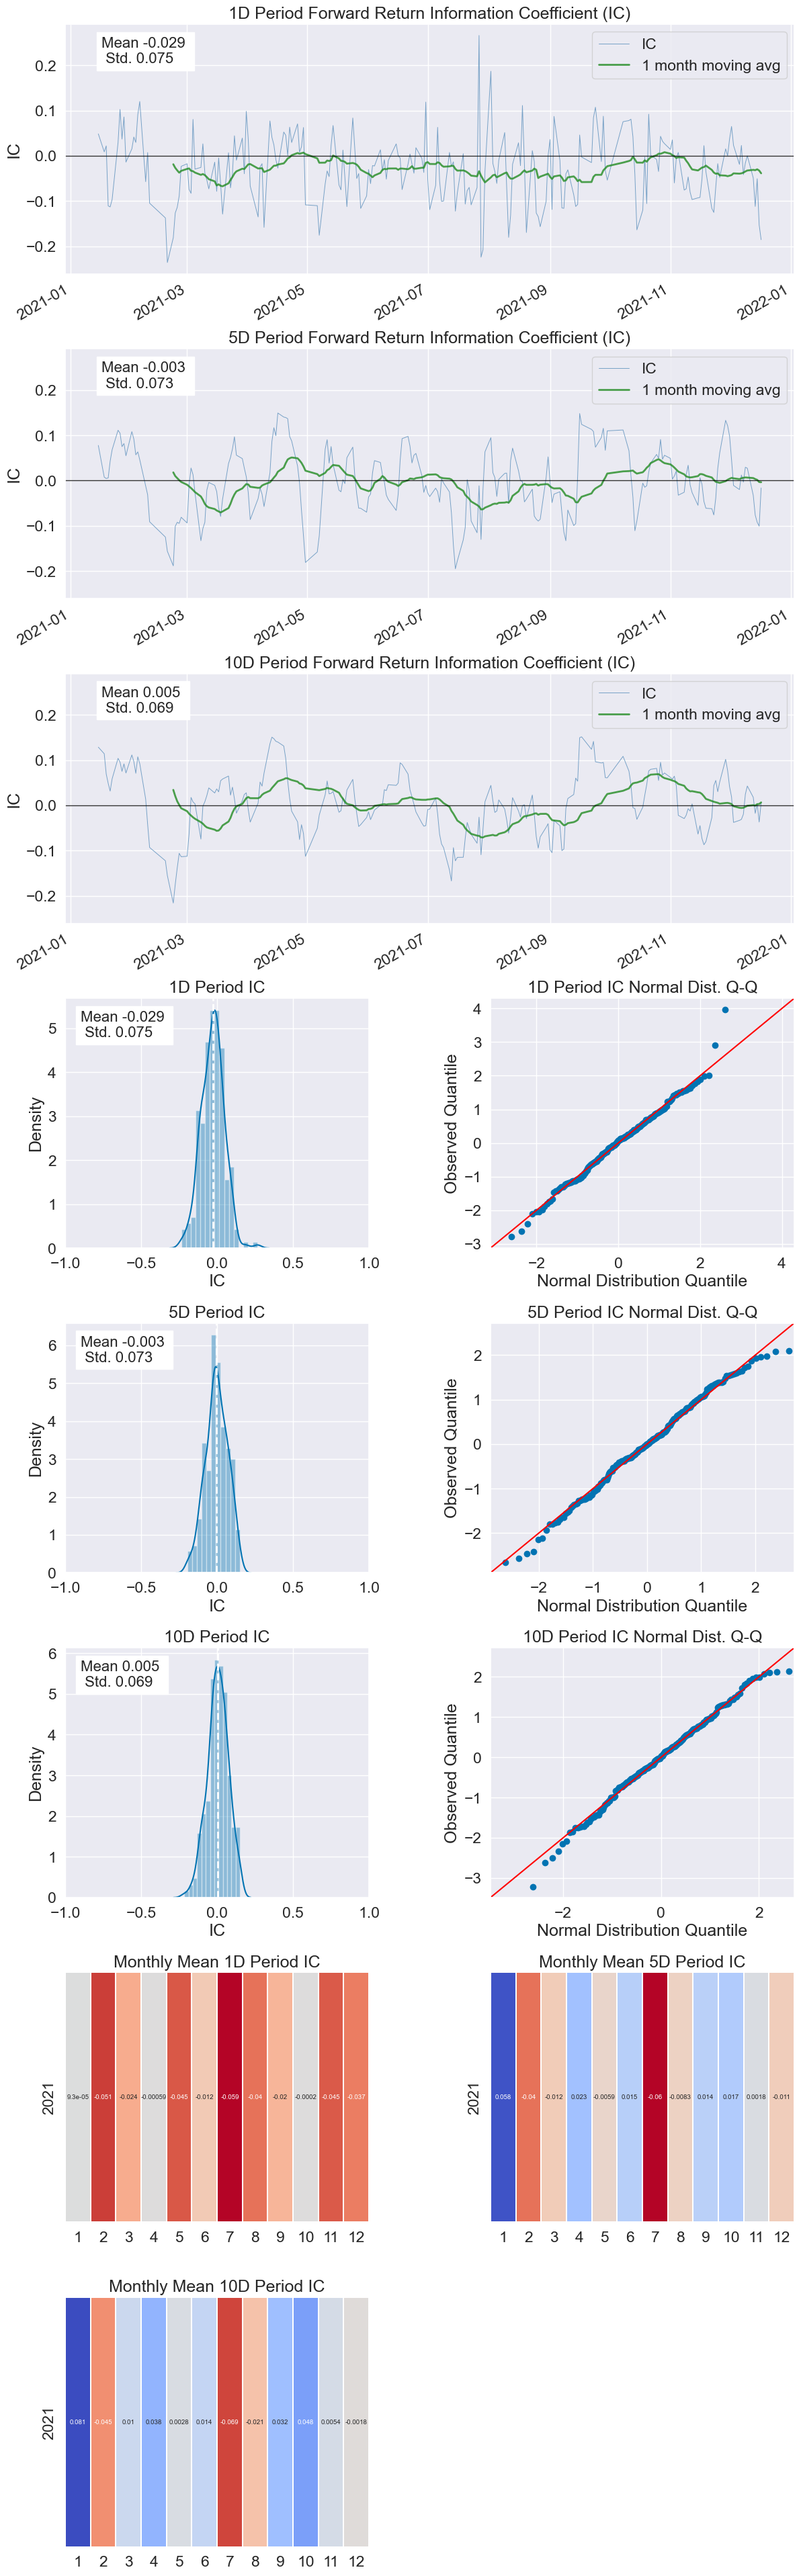

In [22]:
al.tears.create_information_tear_sheet(factor_data,
                                       group_neutral=False,
                                       by_group=False)

## 13.收益率分析

Returns Analysis


,1D,5D,10D
Ann. alpha,-0.194,-0.028,-0.014
beta,-0.490,-0.439,-0.374
Mean Period Wise Return Top Quantile (bps),0.851,6.524,8.018
Mean Period Wise Return Bottom Quantile (bps),25.682,12.357,11.145
Mean Period Wise Spread (bps),-24.831,-5.721,-3.032


<Figure size 640x480 with 0 Axes>

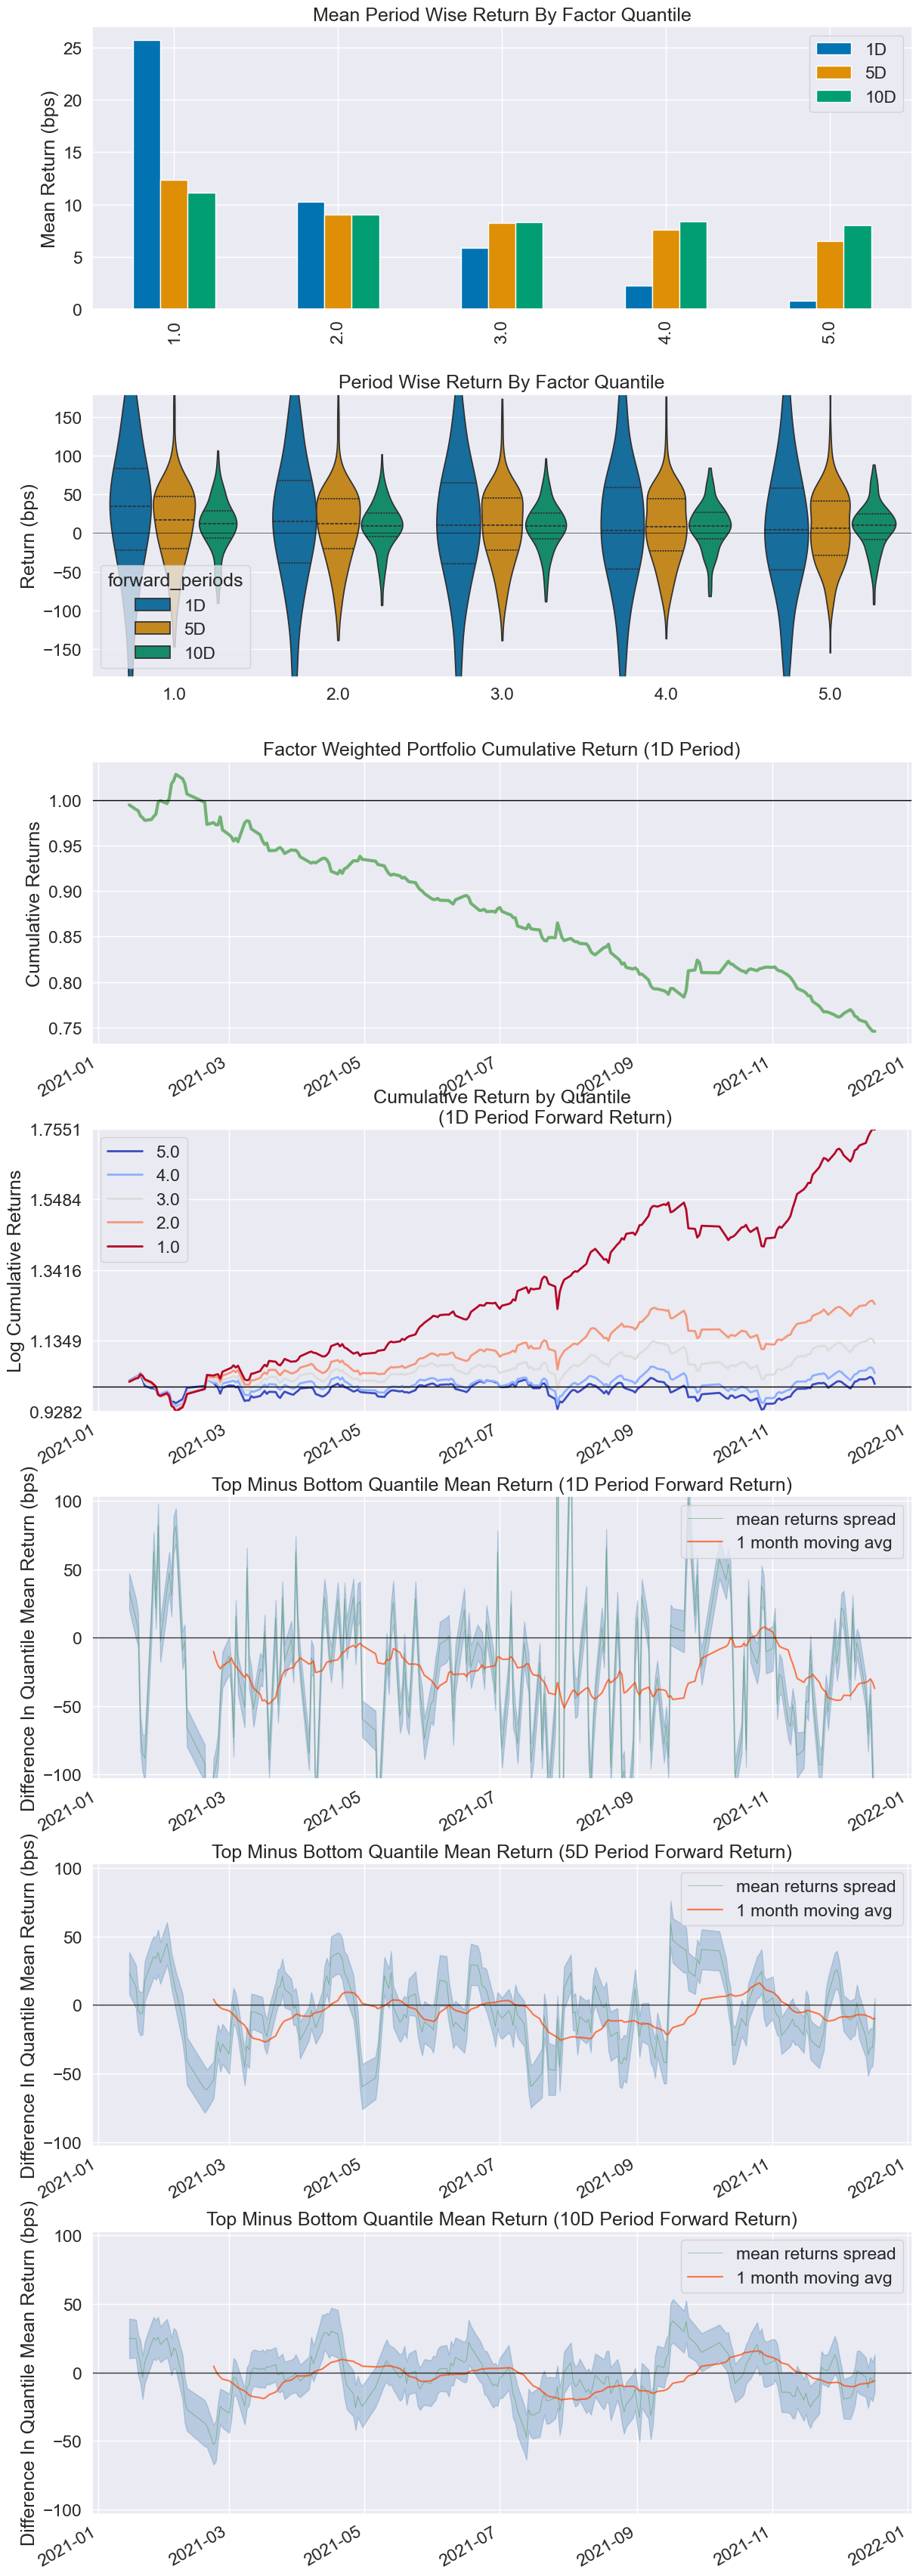

In [23]:
al.tears.create_returns_tear_sheet(factor_data,
                                   long_short=False,
                                   group_neutral=False)

## 14.获取收益序列

In [24]:
mean_quant_ret_bydate, std_quant_daily = perf.mean_return_by_quantile(
    factor_data, by_date=True, by_group=False, demeaned=False
)

In [25]:
mean_quant_rateret_bydate = mean_quant_ret_bydate.apply(
    al.utils.rate_of_return,
    axis=0,
    base_period=mean_quant_ret_bydate.columns[0],
)
mean_quant_rateret_bydate

1D        5D       10D
factor_quantile date                                    
1.0             2021-01-15  0.015307  0.004497 -0.003827
                2021-01-18  0.009401 -0.001600 -0.006023
                2021-01-19  0.000960 -0.004001 -0.005661
                2021-01-20  0.010882 -0.004930 -0.006056
                2021-01-21 -0.004336 -0.007458 -0.008848
...                              ...       ...       ...
5.0             2021-12-13  0.000542 -0.000542 -0.000292
                2021-12-14  0.003235 -0.000946  0.000118
                2021-12-15  0.003498  0.000847  0.000040
                2021-12-16 -0.003979 -0.000578  0.000259
                2021-12-17 -0.016262 -0.002215  0.001149

[1120 rows x 3 columns]

## 15.换手率分析

Turnover Analysis


,1D,5D,10D
Quantile 1.0 Mean Turnover,0.258,0.670,0.736
Quantile 2.0 Mean Turnover,0.489,0.769,0.788
Quantile 3.0 Mean Turnover,0.537,0.784,0.795
Quantile 4.0 Mean Turnover,0.496,0.770,0.790
Quantile 5.0 Mean Turnover,0.265,0.642,0.730


,1D,5D,10D
Mean Factor Rank Autocorrelation,0.859,0.308,0.154


<Figure size 640x480 with 0 Axes>

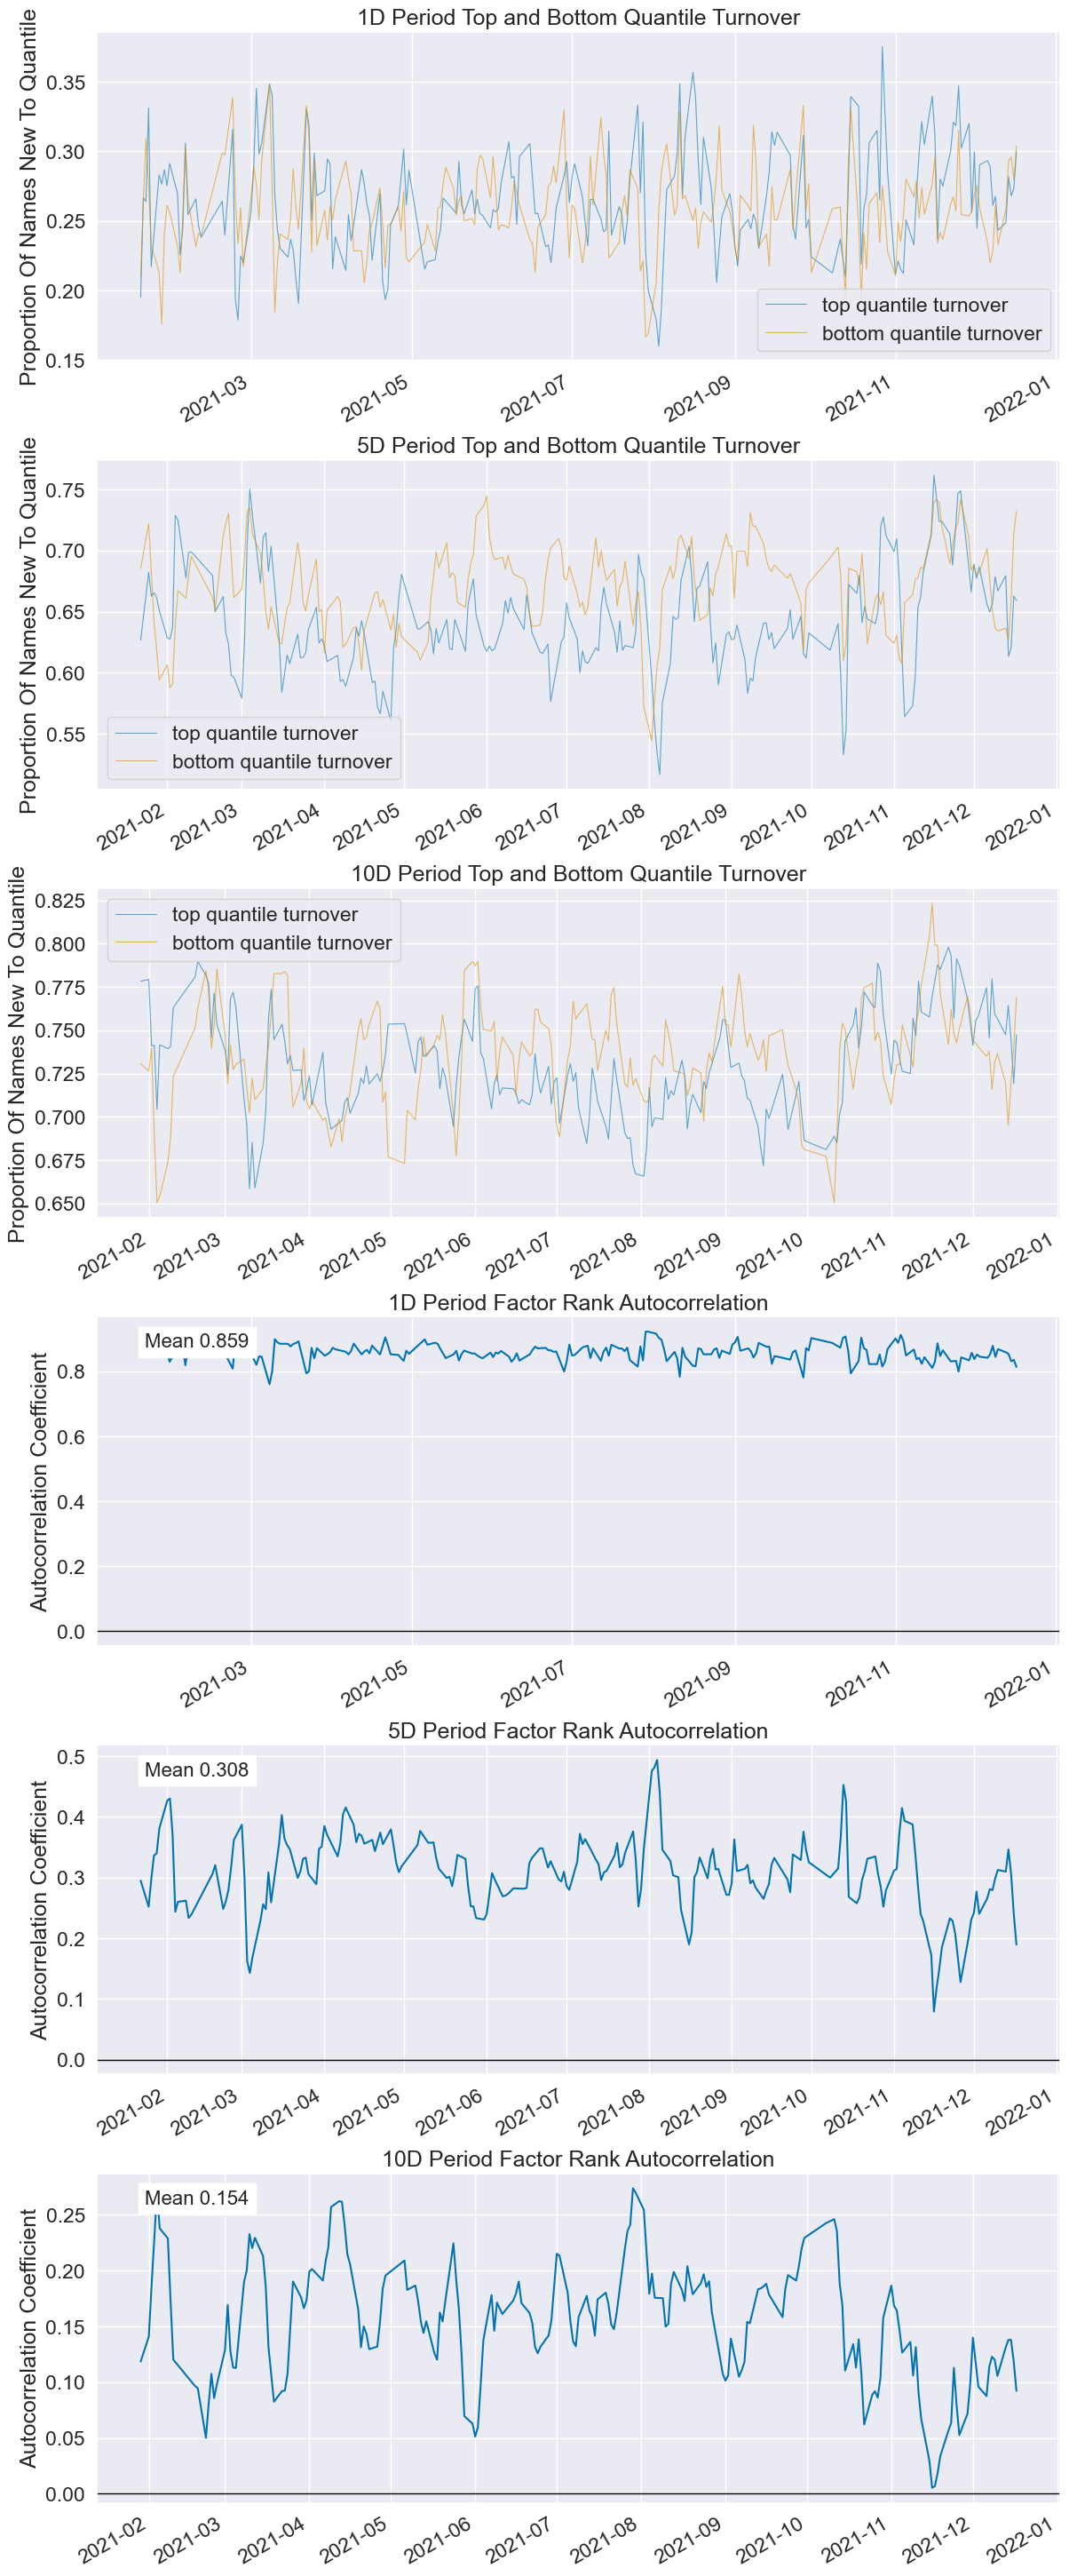

In [26]:
al.tears.create_turnover_tear_sheet(factor_data,turnover_periods=['1D','5D','10D'])